In [1]:
%load_ext autoreload
%autoreload 2

import src.ksd.models as models
from src.ksd.find_modes import find_modes, pairwise_directions, run_bfgs
from src.ksd.langevin import RandomWalkMH, RandomWalkBarker
import src.ksd.langevin as mcmc
from src.ksd.ksd import KSD, SDEKSD, GKSD
from src.ksd.kernel import IMQ, RBF
from src.ksd.bootstrap import Bootstrap
from src.ksd.find_modes import find_modes, pairwise_directions
from tqdm.notebook import tqdm, trange

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns

import src.kgof.density as density
import src.kgof.data as data

MCMCKernel = RandomWalkMH # RandomWalkBarker

In [2]:
tf.random.set_seed(1)

In [3]:
def generate_target_proposal(dim):
    ## single gaussians
    k = 1
    delta = 2.
    
    mean1 = tf.eye(dim)[:, 0] * delta
    mean2 = tf.zeros(dim)

    target = tfd.MultivariateNormalDiag(mean1)
    proposal_off = tfd.MultivariateNormalDiag(mean2)
    
    return target, proposal_off

In [4]:
def plot_bandwidth(dims, kernel_class, n):
    
    bandwidths = []
    for d in dims:
        print(f"dim {d}")
        _, proposal_dist = generate_target_proposal(d)
        X = proposal_dist.sample(n)
        
        kernel = kernel_class(med_heuristic=True)
        kernel.bandwidth(X, tf.identity(X))
        bandwidths.append(kernel.sigma_sq)
        
    # plot
    fig, ax = plt.subplots()
    ax.plot(dims, bandwidths, label="empirical")
    ax.plot(dims, dims, label="theoretical")
    ax.set_ylabel("Bandwidth")
    ax.set_xlabel("Dim")
    ax.legend()
    plt.show()
    
    return bandwidths

In [5]:
dims = [1, 2, 5, 10, 20, 30, 40, 50, 100, 500, 1000]

  0%|          | 0/11 [00:00<?, ?it/s]

dim 1
dim 2
dim 5
dim 10
dim 20
dim 30
dim 40
dim 50
dim 100
dim 500
dim 1000


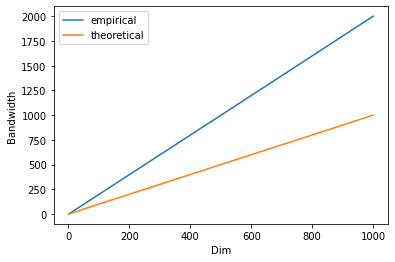

In [9]:
tf.random.set_seed(1)
bandwidths = plot_bandwidth(dims, RBF, n=10000)

In [6]:
def ksd_gaussians(d):
    delta = 2.
    mean1 = tf.eye(dim)[:, 0] * delta
    mean1_norm_sq = np.sum(mean1**2)
    
    res = (2 * np.pi)**(d / 2) * d / (np.sqrt(2 * d + 2)) * mean1_norm_sq
    return res

In [7]:
def plot_ksd(dims, kernel_class, n):
    
    ksd_empirical_list = []
    for d in dims:
        print(f"dim: {d}")
        target, proposal_dist = generate_target_proposal(d)
        X = proposal_dist.sample(n)
        
        # compute ksd empirically
        kernel = kernel_class(med_heuristic=True)
        ksd = KSD(kernel=kernel, log_prob=target.log_prob)
        ksd_val = ksd(X, tf.identity(X))
        
        ksd_empirical_list.append(ksd_val)
        
    # compute ksd from theoretical formula
    ksd_theoretical_list = ksd_gaussians(dims)
        
    fig, ax = plt.subplots()
    ax.plot(dims, ksd_empirical_list, label="empirical")
    ax.plot(dims, ksd_theoretical_list, label="theoretical")
    ax.set_ylabel("KSD")
    ax.set_xlabel("Dim")
    
    return ksd_empirical_list, ksd_theoretical_list

In [ ]:
tf.random.set_seed(1)
ksd_empirical_list, ksd_theoretical_list = plot_ksd(dims, RBF, n=1000)

dim: 1
dim: 2


2022-10-21 10:36:48.592891: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-21 10:36:48.592943: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: nvidia4
2022-10-21 10:36:48.592950: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: nvidia4
2022-10-21 10:36:48.593083: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.27.4
2022-10-21 10:36:48.593112: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.27.4
2022-10-21 10:36:48.593118: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.27.4
2022-10-21 10:36:48.593597: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in pe

dim: 5
dim: 10
dim: 20
dim: 30
dim: 40
dim: 50
dim: 100
dim: 500


2022-10-21 10:37:30.733537: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1000000000000 exceeds 10% of free system memory.
